<a href="https://colab.research.google.com/github/alexlopespereira/machine_learning/blob/main/Notebooks/Aula2/Aula2_02_CarsPricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Preço de Automóveis em Faixas
### Usando Rede Neural (MLPClassifier) do scikit-learn

Este *notebook* realiza a classificação do preço de automóveis em três faixas (baixo, médio, alto), definidas pelos percentis de 33% e 66%. São realizadas as seguintes etapas:

1. **Carregamento** e **exploração inicial** dos dados.
2. **Limpeza** de dados (tratamento de valores faltantes, conversão de tipos).
3. **Categorização** da variável *price* em faixas.
4. **Análise exploratória** simples (histograma e mapa de calor de correlação).
5. **Conversão** de variáveis categóricas em *dummies* (One-Hot Encoding).
6. **Normalização** das variáveis numéricas (MinMaxScaler).
7. **Seleção de variáveis** (RFE) usando *LogisticRegression* como estimador base.
8. **Rede Neural MLP** para classificação (MLPClassifier do scikit-learn).
9. **Avaliação** do modelo (matriz de confusão, relatório de classificação, acurácia).

> **Observação**: O RFE utiliza `LogisticRegression` internamente, pois o `MLPClassifier` não disponibiliza coeficientes/atributos de importância de forma direta para a seleção de variáveis.

Vamos iniciar o processo!

## 1. Importação das Bibliotecas
*Nesta etapa, importamos as bibliotecas Python necessárias para o projeto.*

**Detalhes sobre algumas funções**:
- `warnings.filterwarnings('ignore')`: suprime avisos que podem poluir a saída.
- `pandas` (`pd`): manipulação de dataframes.
- `numpy` (`np`): operações matemáticas/vetoriais.
- `matplotlib.pyplot` (`plt`) e `seaborn` (`sns`): geração de gráficos e visualizações.
- `LogisticRegression`: modelo linear usado aqui somente para o processo de RFE.
- `MLPClassifier`: rede neural *Multilayer Perceptron* para classificação.
- `RFE`: *Recursive Feature Elimination*, método de seleção de variáveis.
- `MinMaxScaler`: normalização dos dados para o intervalo [0,1].
- `train_test_split`: separa dados em conjunto de treino e teste.
- `classification_report`, `confusion_matrix`, `accuracy_score`: métricas de avaliação.

In [ ]:
import warnings
warnings.filterwarnings('ignore') # O que isso faz?

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## 2. Carregamento e Breve Exploração do Dataset
*Nesta seção, carregamos o arquivo CSV com os dados dos automóveis e fazemos uma exploração inicial.*

**Funções e argumentos**:
- `pd.read_csv('Automobile.csv')`: lê o arquivo CSV e retorna um dataframe.
- `df.head(10)`: exibe as primeiras 10 linhas do dataframe.
- `df.info()`: mostra resumo das colunas, tipos e quantidade de dados não-nulos.
- `df.describe()`: gera estatísticas descritivas para colunas numéricas.

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch dataset
automobile = fetch_ucirepo(id=10)

# Data (as pandas dataframes)
X = automobile.data.features  # features
y = automobile.data.targets   # target

# Optionally, rename the target column if you'd like a more descriptive name
# y.columns = ["price"]  # for example

# Combine into a single DataFrame
df = pd.concat([X, y], axis=1)

In [ ]:
print("Amostra do dataset original:")
display(df.head(10))

print("\nInformações do dataset:")
print(df.info())

print("\nDescrição estatística das colunas numéricas:")
display(df.describe())

Amostra do dataset original:


,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses,price
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN,3
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN,3
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN,1
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0,2
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0,2
5,15250.0,25,19,5500.0,110.0,8.5,3.40,3.19,mpfi,136,...,99.8,front,fwd,sedan,2.0,std,gas,audi,NaN,2
6,17710.0,25,19,5500.0,110.0,8.5,3.40,3.19,mpfi,136,...,105.8,front,fwd,sedan,4.0,std,gas,audi,158.0,1
7,18920.0,25,19,5500.0,110.0,8.5,3.40,3.19,mpfi,136,...,105.8,front,fwd,wagon,4.0,std,gas,audi,NaN,1
8,23875.0,20,17,5500.0,140.0,8.3,3.40,3.13,mpfi,131,...,105.8,front,fwd,sedan,4.0,turbo,gas,audi,158.0,1
9,NaN,22,16,5500.0,160.0,7.0,3.40,3.13,mpfi,131,...,99.5,front,4wd,hatchback,2.0,turbo,gas,audi,NaN,0



Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              201 non-null    float64
 1   highway-mpg        205 non-null    int64  
 2   city-mpg           205 non-null    int64  
 3   peak-rpm           203 non-null    float64
 4   horsepower         203 non-null    float64
 5   compression-ratio  205 non-null    float64
 6   stroke             201 non-null    float64
 7   bore               201 non-null    float64
 8   fuel-system        205 non-null    object 
 9   engine-size        205 non-null    int64  
 10  num-of-cylinders   205 non-null    int64  
 11  engine-type        205 non-null    object 
 12  curb-weight        205 non-null    int64  
 13  height             205 non-null    float64
 14  width              205 non-null    float64
 15  length             205 non-null    float64
 16  w

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,engine-size,num-of-cylinders,curb-weight,height,width,length,wheel-base,num-of-doors,normalized-losses,price
count,201.000000,205.000000,205.000000,203.000000,203.000000,205.000000,201.000000,201.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,203.000000,164.000000,205.000000
mean,13207.129353,30.751220,25.219512,5125.369458,104.256158,10.142537,3.255423,3.329751,126.907317,4.380488,2555.565854,53.724878,65.907805,174.049268,98.756585,3.123153,122.000000,0.834146
std,7947.066342,6.886443,6.542142,479.334560,39.714369,3.972040,0.316717,0.273539,41.642693,1.080854,520.680204,2.443522,2.145204,12.337289,6.021776,0.994841,35.442168,1.245307
min,5118.000000,16.000000,13.000000,4150.000000,48.000000,7.000000,2.070000,2.540000,61.000000,2.000000,1488.000000,47.800000,60.300000,141.100000,86.600000,2.000000,65.000000,-2.000000
25%,7775.000000,25.000000,19.000000,4800.000000,70.000000,8.600000,3.110000,3.150000,97.000000,4.000000,2145.000000,52.000000,64.100000,166.300000,94.500000,2.000000,94.000000,0.000000
50%,10295.000000,30.000000,24.000000,5200.000000,95.000000,9.000000,3.290000,3.310000,120.000000,4.000000,2414.000000,54.100000,65.500000,173.200000,97.000000,4.000000,115.000000,1.000000
75%,16500.000000,34.000000,30.000000,5500.000000,116.000000,9.400000,3.410000,3.590000,141.000000,4.000000,2935.000000,55.500000,66.900000,183.100000,102.400000,4.000000,150.000000,2.000000
max,45400.000000,54.000000,49.000000,6600.000000,288.000000,23.000000,4.170000,3.940000,326.000000,12.000000,4066.000000,59.800000,72.300000,208.100000,120.900000,4.000000,256.000000,3.000000


## 3. Limpeza de Dados
*Substituímos valores faltantes (`?`) por `NaN`, removemos linhas com dados ausentes e convertemos colunas numéricas.*

**Funções e argumentos**:
- `df.replace('?', np.nan, inplace=True)`: substitui `?` por `NaN` no próprio dataframe.
- `df.dropna(axis=0, how='any', inplace=True)`: remove linhas com qualquer valor faltante.
- `pd.to_numeric(..., errors='coerce')`: converte para número, transformando valores inválidos em `NaN`.

In [ ]:
# Substituir valores '?' por NaN
df.replace('?', np.nan, inplace=True)

# Definir colunas que devem ser numéricas
numerical_cols = ['price', 'bore', 'stroke', 'horsepower', 'peak-rpm']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remover registros com valores nulos
df.dropna(axis=0, how='any', inplace=True)

print("\nTamanho do dataframe após remoção de NaNs:", df.shape)
print("\nDescrição estatística após limpeza:")
display(df.describe())

print("\nVerificar tipos de dados pós-limpeza:")
print(df.dtypes)


Tamanho do dataframe após remoção de NaNs: (159, 26)

Descrição estatística após limpeza:


,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,engine-size,num-of-cylinders,curb-weight,height,width,length,wheel-base,num-of-doors,normalized-losses,symboling
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,11445.729560,32.081761,26.522013,5113.836478,95.836478,10.161132,3.236352,3.300126,119.226415,4.238994,2461.138365,53.899371,65.607547,172.413836,98.264151,3.194969,121.132075,0.735849
std,5877.856195,6.459189,6.097142,465.754864,30.718583,3.889475,0.294888,0.267336,30.460791,0.669962,481.941321,2.268761,1.947883,11.523177,5.167416,0.983908,35.651285,1.193086
min,5118.000000,18.000000,15.000000,4150.000000,48.000000,7.000000,2.070000,2.540000,61.000000,3.000000,1488.000000,49.400000,60.300000,141.100000,86.600000,2.000000,65.000000,-2.000000
25%,7372.000000,28.000000,23.000000,4800.000000,69.000000,8.700000,3.105000,3.050000,97.000000,4.000000,2065.500000,52.250000,64.000000,165.650000,94.500000,2.000000,94.000000,0.000000
50%,9233.000000,32.000000,26.000000,5200.000000,88.000000,9.000000,3.270000,3.270000,110.000000,4.000000,2340.000000,54.100000,65.400000,172.400000,96.900000,4.000000,113.000000,1.000000
75%,14719.500000,37.000000,31.000000,5500.000000,114.000000,9.400000,3.410000,3.560000,135.000000,4.000000,2809.500000,55.500000,66.500000,177.800000,100.800000,4.000000,148.000000,2.000000
max,35056.000000,54.000000,49.000000,6600.000000,200.000000,23.000000,4.170000,3.940000,258.000000,8.000000,4066.000000,59.800000,71.700000,202.600000,115.600000,4.000000,256.000000,3.000000



Verificar tipos de dados pós-limpeza:
price                float64
highway-mpg            int64
city-mpg               int64
peak-rpm             float64
horsepower           float64
compression-ratio    float64
stroke               float64
bore                 float64
fuel-system           object
engine-size            int64
num-of-cylinders       int64
engine-type           object
curb-weight            int64
height               float64
width                float64
length               float64
wheel-base           float64
engine-location       object
drive-wheels          object
body-style            object
num-of-doors         float64
aspiration            object
fuel-type             object
make                  object
normalized-losses    float64
symboling              int64
dtype: object


## 4. Criação da Variável Alvo (Categorização do Preço)
*Definimos duas faixas de corte (percentis de 33% e 66%) para classificar o preço em: 'low', 'medium' ou 'high'.*

**Funções e argumentos**:
- `np.percentile(df['price'], 33)`: retorna o valor do 33º percentil da coluna `price`.
- `df.apply(...)`: aplica uma função em cada valor da coluna `price`.

In [ ]:
# Calcular os percentis 33 e 66
p33 = np.percentile(df['price'], 33)
p66 = np.percentile(df['price'], 66)

print(f"\nValor do 33o percentil: {p33:.2f}")
print(f"Valor do 66o percentil: {p66:.2f}")

def categorize_price(x):
    if x <= p33:
        return 'low'
    elif x <= p66:
        return 'medium'
    else:
        return 'high'

df['price_category'] = df['price'].apply(categorize_price)

print("\nDistribuição das categorias de preço:")
display(df['price_category'].value_counts())


Valor do 33o percentil: 7895.42
Valor do 66o percentil: 11340.20

Distribuição das categorias de preço:


,count
price_category,
high,54
low,53
medium,52


## 5. Análise Exploratória Básica
*Exibimos um histograma para visualizar a distribuição de preços e um mapa de calor das correlações entre variáveis numéricas.*

**Funções e argumentos**:
- `sns.histplot(...)`: gera um histograma com opção de curva *kde*.
- `sns.heatmap(...)`: mostra uma matriz de correlação com coloração, `annot=True` exibe valores numéricos.
- `corr()`: calcula a correlação de Pearson entre as colunas numéricas de um DataFrame.

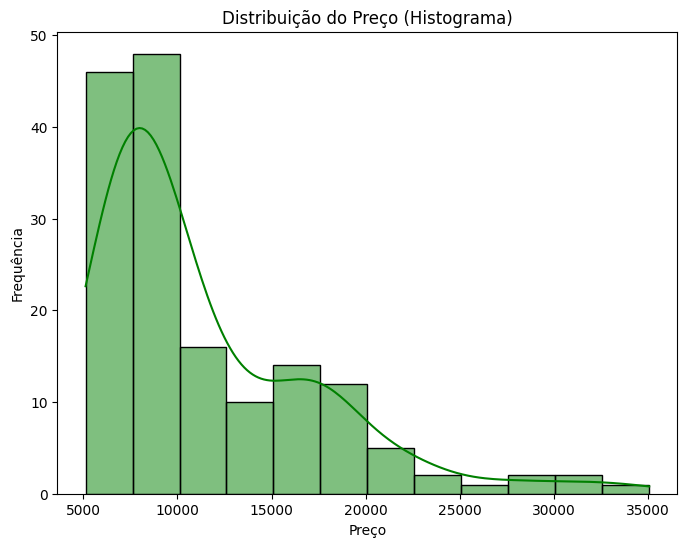

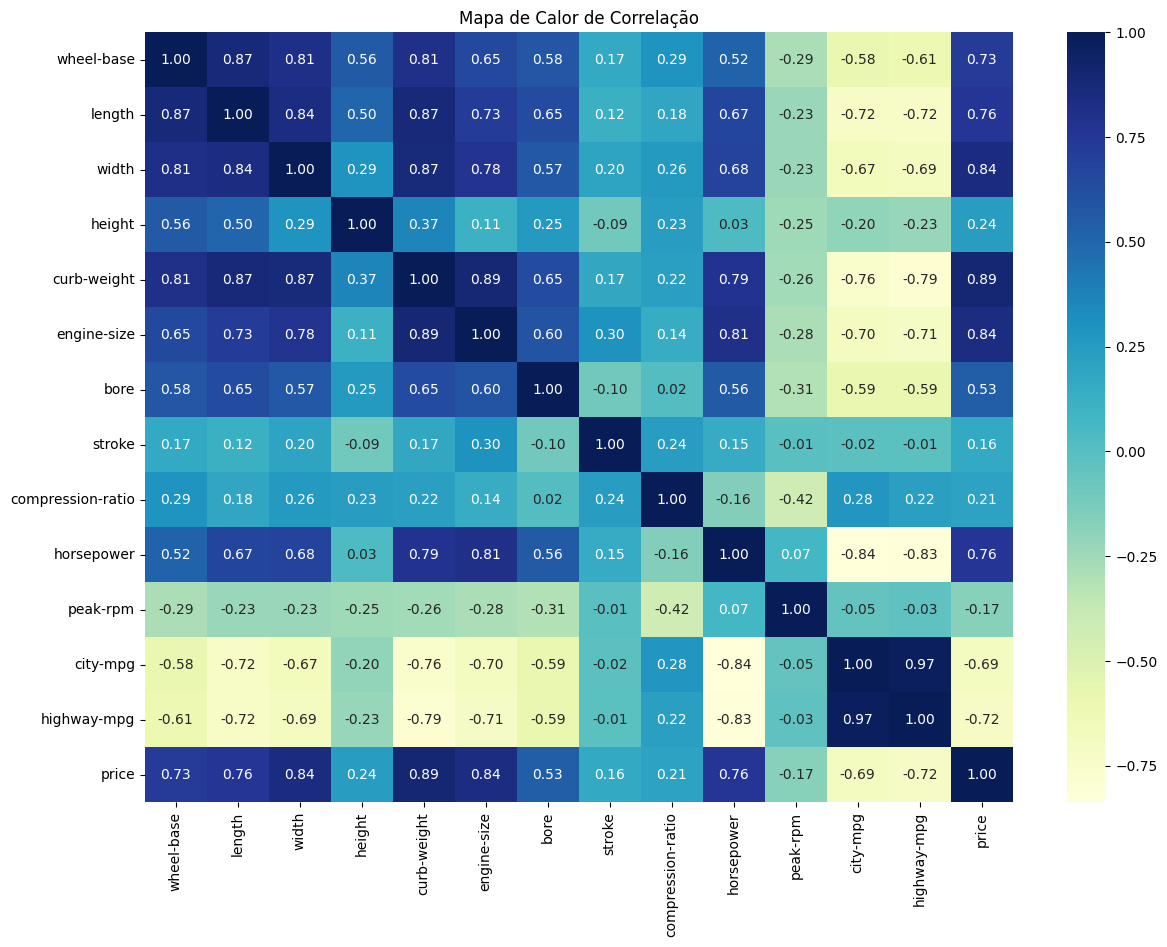

In [ ]:
# Histograma do preço
plt.figure(figsize=(8, 6))
sns.histplot(df['price'], kde=True, color='green')
plt.title('Distribuição do Preço (Histograma)')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

# Mapa de calor de correlação
numerical_cols_2 = ['wheel-base','length','width','height','curb-weight',
                    'engine-size','bore','stroke','compression-ratio','horsepower',
                    'peak-rpm','city-mpg','highway-mpg','price']
corr_matrix = df[numerical_cols_2].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Mapa de Calor de Correlação')
plt.show()

## 6. Conversão de Variáveis Categóricas em *Dummies*
*Usamos `pd.get_dummies` para criar variáveis binárias (0/1) a partir de colunas categóricas.*

**Funções e argumentos**:
- `pd.get_dummies(df[cat_cols], drop_first=True)`: cria colunas *dummy* para cada categoria, removendo a primeira (referência) para evitar a *dummy trap*.
- `pd.concat([...], axis=1)`: concatena dataframes lado a lado.

In [ ]:
# Definir colunas categóricas
cat_cols = ['make','fuel-type','aspiration','num-of-doors','body-style',
            'drive-wheels','engine-location','engine-type','num-of-cylinders',
            'fuel-system']

# Criar dummies
df_dummies = pd.get_dummies(df[cat_cols], drop_first=True)
df = pd.concat([df, df_dummies], axis=1)

# Remover as colunas categóricas originais
df.drop(columns=cat_cols, inplace=True)

print("\nExemplo das colunas dummy:")
display(df_dummies.head(5))


Exemplo das colunas dummy:


,num-of-doors,num-of-cylinders,make_bmw,make_chevrolet,make_dodge,make_honda,make_jaguar,make_mazda,make_mercedes-benz,make_mitsubishi,...,drive-wheels_rwd,engine-type_l,engine-type_ohc,engine-type_ohcf,engine-type_ohcv,fuel-system_2bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi
3,4.0,4,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,4.0,5,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
6,4.0,5,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
8,4.0,5,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
10,2.0,4,True,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,True,False


## 7. Normalização das Variáveis Numéricas
*Aplicamos `MinMaxScaler` para escalar cada coluna numérica para o intervalo [0,1].*

**Funções e argumentos**:
- `MinMaxScaler(feature_range=(0,1))`: (padrão) transforma cada valor x em (x - min) / (max - min).
- `scaler.fit_transform(...)`: primeiro *aprende* (fit) os valores mínimo e máximo das colunas, depois transforma os dados.

In [ ]:
# Selecionar as colunas numéricas para normalizar (exceto a nova coluna price_category)
num_cols_for_scaling = ['wheel-base','length','width','height','curb-weight',
                        'engine-size','bore','stroke','compression-ratio',
                        'horsepower','peak-rpm','city-mpg','highway-mpg','price']

scaler = MinMaxScaler()
df[num_cols_for_scaling] = scaler.fit_transform(df[num_cols_for_scaling])

print("\nExemplo das variáveis normalizadas:")
display(df[num_cols_for_scaling].head())


Exemplo das variáveis normalizadas:


,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,0.455172,0.577236,0.517544,0.471154,0.329325,0.243655,0.464286,0.633333,0.18750,0.355263,0.551020,0.264706,0.333333,0.295010
4,0.441379,0.577236,0.535088,0.471154,0.518231,0.380711,0.464286,0.633333,0.06250,0.440789,0.551020,0.088235,0.111111,0.411918
6,0.662069,0.839024,0.973684,0.605769,0.525989,0.380711,0.464286,0.633333,0.09375,0.407895,0.551020,0.117647,0.194444,0.420603
8,0.662069,0.839024,0.973684,0.625000,0.619860,0.355330,0.421429,0.633333,0.08125,0.605263,0.551020,0.058824,0.055556,0.626528
10,0.503448,0.580488,0.394737,0.471154,0.351823,0.238579,0.685714,0.347619,0.11250,0.348684,0.673469,0.235294,0.305556,0.377848


## 8. Definição de X e y
*O vetor de rótulos (`y`) será `price_category`. Em `X`, removemos tanto `price_category` quanto `price` (pois o modelo deve prever a categoria sem ver o preço real).*

**Funções e argumentos**:
- `df.drop(columns=[...])`: remove colunas específicas do dataframe.

In [ ]:
y = df['price_category'].values
X = df.drop(columns=['price_category','price'])

print(f"\nDimensão de X: {X.shape}")
print(f"Dimensão de y: {y.shape}")


Dimensão de X: (159, 49)
Dimensão de y: (159,)


## 9. Seleção de Variáveis com RFE
*Usamos `LogisticRegression` como estimador para o RFE, a fim de selecionar as 10 melhores variáveis (características) para classificar `price_category`.*

**Funções e argumentos**:
- `LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)`: modelo de regressão logística multiclasse, usando o método `lbfgs` e limite de 500 iterações.
- `RFE(estimator=..., n_features_to_select=10)`: elimina recursivamente as variáveis menos importantes, até restarem 10 selecionadas.
- `rfe.fit(X, y)`: executa o processo de seleção no conjunto de dados.
- `rfe.support_`: array booleano indicando quais colunas foram mantidas.

In [ ]:
base_estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
rfe = RFE(estimator=base_estimator, n_features_to_select=10)

rfe.fit(X, y)

selected_columns = X.columns[rfe.support_]
print("\nColunas selecionadas pelo RFE:")
print(selected_columns)

# Criar novo X somente com as colunas selecionadas
X_selected = X[selected_columns]


Colunas selecionadas pelo RFE:
Index(['highway-mpg', 'city-mpg', 'horsepower', 'curb-weight', 'width',
       'length', 'wheel-base', 'drive-wheels_fwd', 'fuel-system_2bbl',
       'fuel-system_mpfi'],
      dtype='object')


## 10. Divisão em Treino e Teste
*Dividimos o dataset em 70% treino e 30% teste, estratificando pela variável alvo (`price_category`).*

**Funções e argumentos**:
- `train_test_split(X_selected, y, test_size=0.30, stratify=y, random_state=42)`: separa dados em treino e teste; 30% vai para teste. `stratify=y` mantém a proporção de classes, `random_state=42` define uma semente para reprodutibilidade.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.30, random_state=42, stratify=y
)

print("\nDimensões do conjunto de treino:", X_train.shape, y_train.shape)
print("Dimensões do conjunto de teste:", X_test.shape, y_test.shape)


Dimensões do conjunto de treino: (111, 10) (111,)
Dimensões do conjunto de teste: (48, 10) (48,)


## 11. Treinamento da Rede Neural (MLPClassifier)
*Definimos um `MLPClassifier` com duas camadas ocultas (16 e 8 neurônios), função de ativação `'relu'` e solver `'adam'`. Podemos ajustar o número de iterações (`max_iter`) caso seja necessário mais tempo para convergir.*

**Funções e argumentos**:
- `MLPClassifier(hidden_layer_sizes=(16,8), activation='relu', solver='adam', max_iter=2000, random_state=42)`: cria uma rede neural com 2 camadas ocultas, cada qual contendo 16 e 8 neurônios, respectivamente. A função de ativação `'relu'` (Rectified Linear Unit) é uma das mais usadas em redes neurais. O `'adam'` é um método de otimização. `max_iter=2000` define o número máximo de épocas (iterações) de treinamento. `random_state=42` garante reprodutibilidade dos resultados.
- `mlp.fit(X_train, y_train)`: treina (ajusta) os pesos da rede neural nos dados de treino.

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(16, 8), max_iter=2000, random_state=42)

## 12. Avaliação do Modelo
*Utilizamos a rede treinada para prever no conjunto de teste. Avaliamos por meio da matriz de confusão, relatório de classificação (contendo precisão, recall e F1), e acurácia geral.*

**Funções e argumentos**:
- `mlp.predict(X_test)`: gera as previsões de classe para cada amostra do conjunto de teste.
- `confusion_matrix(y_test, y_pred, labels=[...])`: produz uma matriz de confusão, onde `labels` define a ordem das classes.
- `sns.heatmap(...)`: usada para plotar a matriz de confusão com anotações.
- `classification_report(...)`: exibe precisão, recall, F1-score e suporte para cada classe.
- `accuracy_score(...)`: exibe a fração de acertos (quantos % das amostras foram classificadas corretamente).


Matriz de Confusão:


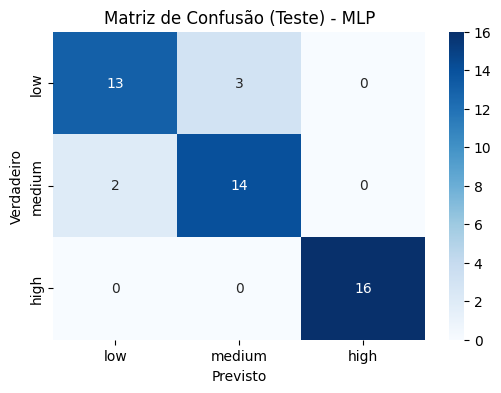


Relatório de Classificação:
              precision    recall  f1-score   support

        high      1.000     1.000     1.000        16
         low      0.867     0.812     0.839        16
      medium      0.824     0.875     0.848        16

    accuracy                          0.896        48
   macro avg      0.897     0.896     0.896        48
weighted avg      0.897     0.896     0.896        48

Acurácia no teste: 89.58%


In [ ]:
y_pred = mlp.predict(X_test)

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred, labels=['low','medium','high'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['low','medium','high'],
            yticklabels=['low','medium','high'])
plt.title("Matriz de Confusão (Teste) - MLP")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, digits=3))

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia no teste: {acc*100:.2f}%")

## 13. Conclusões
*Resumo dos resultados e possíveis pontos de melhoria.*

- **Rede Neural MLP**: demonstrou capacidade de separar bem as faixas de preço dos automóveis (baixo, médio, alto) após o pré-processamento e seleção de variáveis.
- **RFE**: mesmo utilizando uma regressão logística como estimador, ajudou a reduzir a dimensionalidade, selecionando os atributos mais relevantes.
- **Métricas**: acurácia, precisão, recall e F1-score podem indicar se o modelo está equilibrado entre as classes. Uma boa prática é analisar se há confusão excessiva entre *low* e *medium*, ou entre *medium* e *high*.
- Poderíamos **ajustar hiperparâmetros** (como número de neurônios, camadas, função de ativação, taxa de aprendizado) para melhorar ainda mais o desempenho.
- **Interpretação**: apesar de redes neurais serem modelos mais "caixa-preta", a abordagem utilizada (RFE + MLP) ainda pode fornecer insights sobre quais *features* são mais importantes (via RFE) e como afetam a classificação de preço.